## RL simulation analyses

In [1]:
import sys
import os
base_path = "/home/ubuntu/Projects/RL_sim/"
sys.path.insert(0, base_path)
os.chdir(base_path)

from scipy.stats import t
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

%matplotlib inline

In [2]:
#### Parameter grid ####
parameters = {
    'snr': [0.5, 1, 2, 5, 10],
    'n_bins': [30],
    'q_mean': [0],
    'q_sigma': [0.1],
    'kernel_size': [15],
    'kernel_sigma': [1.0, 2.0, 3.0, 5.0],
    'learning_rate': [0.1, 0.3, 0.5, 0.8, 0.9, 0.95, 0.99],
    'temperature': [1e-5, 0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1.0],
    'min_temperature': [1e-5],
    'max_temperature': [1.0],
    'reduce_temperature': [False],
    'decay_rate': [0.001]
}

# load data;
data = pd.read_pickle("./results/data.pkl")
print("Unique combinations of parameters", data.shape[0])

Unique combinations of parameters 12600000


## Summarize parameter search

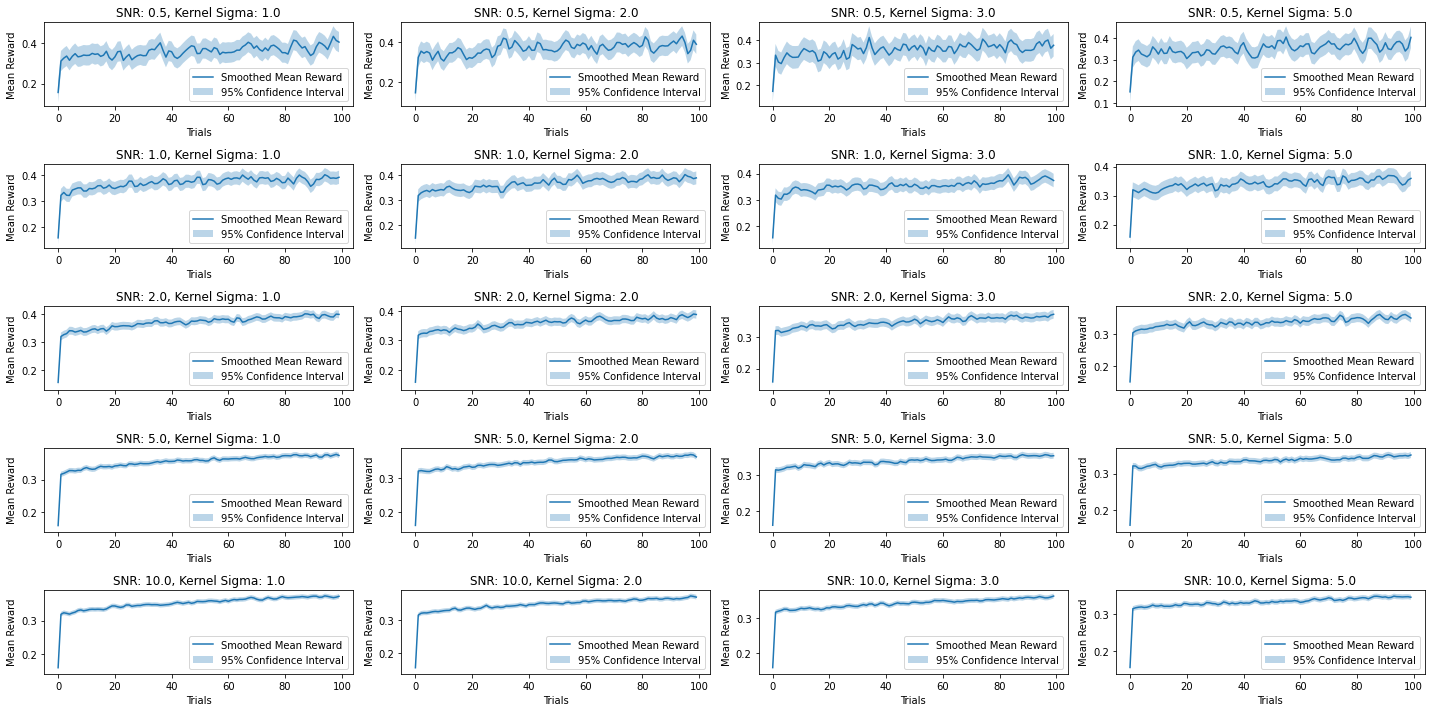

In [18]:
# set up variables;
unique_snr_values = data["snr"].unique()
unique_kernel_sigma_values = data["kernel_sigma"].unique()
unique_learning_rate_values = data["learning_rate"].unique()
unique_temperature_values = data["temperature"].unique()

# Generate combinations of snr and kernel_sigma
snr_kernel_combinations = list(itertools.product(
    unique_snr_values,
    unique_kernel_sigma_values
))

# Generate all combinations of snr, kernel_sigma, lr, and temp
lr_temp_combinations = list(itertools.product(
    unique_learning_rate_values,
    unique_temperature_values
))

num_rows = len(unique_snr_values)
num_cols = len(unique_kernel_sigma_values)
row_idx = 0
col_idx = 0

n_epochs = 100
epoch_length = list(range(0, n_epochs))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# loop through all combinations;
for idx, (snr, kernel_sigma) in enumerate(snr_kernel_combinations):
    # vars to save trials data;
    trial_summary = []
    trial_ci = []
    trial_best_lr = []
    trial_best_temp = []

    # get data for current parameters;
    sub_data = data[(data['snr'] == snr) & (data['kernel_sigma'] == kernel_sigma)]

    # generate subplot data;
    for epoch in epoch_length:
        trial_data = sub_data[sub_data["epochs"] == epoch]
        trial_summary.append(np.mean(trial_data["reward"]))

        # Calculate the 95% confidence interval
        confidence_interval = t.interval(0.95, len(trial_data["reward"]) - 1,
                                         loc=np.mean(trial_data["reward"]),
                                         scale=np.std(trial_data["reward"]) / np.sqrt(len(trial_data["reward"])))
        trial_ci.append((confidence_interval[1] - confidence_interval[0]) / 2)

    # Apply median smoothing to trial_summary using a rolling window
    window_size = 2
    smoothed_summary = np.convolve(trial_summary, np.ones(window_size)/window_size, mode='same')

    # Plot the smoothed line
    axs[row_idx, col_idx].plot(epoch_length, smoothed_summary, label='Smoothed Mean Reward')

    # Fill the 95% confidence interval
    lower_bound = np.array(smoothed_summary) - np.array(trial_ci)
    upper_bound = np.array(smoothed_summary) + np.array(trial_ci)
    axs[row_idx, col_idx].fill_between(epoch_length, lower_bound, upper_bound, alpha=0.3, label='95% Confidence Interval')

    axs[row_idx, col_idx].set_xlabel("Trials")
    axs[row_idx, col_idx].set_ylabel("Mean Reward")
    axs[row_idx, col_idx].set_title(f"SNR: {snr}, Kernel Sigma: {kernel_sigma}")
    axs[row_idx, col_idx].legend()

    # correctly index subplots
    col_idx += 1
    if col_idx == num_cols:
        row_idx += 1
        col_idx = 0

# adjust layout;
plt.tight_layout()
plt.show()

## Check best Learning Rate and Temperature:

In [ ]:
# set up variables;
unique_snr_values = data["snr"].unique()
unique_kernel_sigma_values = data["kernel_sigma"].unique()
unique_learning_rate_values = data["learning_rate"].unique()
unique_temperature_values = data["temperature"].unique()

# Generate combinations of snr and kernel_sigma
snr_kernel_combinations = list(itertools.product(
    unique_snr_values,
    unique_kernel_sigma_values
))

# Generate all combinations of snr, kernel_sigma, lr, and temp
lr_temp_combinations = list(itertools.product(
    unique_learning_rate_values,
    unique_temperature_values
))

best_models = []
for lr, temp in lr_temp_combinations:
    sub_data = data[(data['learning_rate'] == lr) & (data['temperature'] == temp)]

    # get best lr and temperature for the current set of parameters;
    best_lr, best_temp = sub_data.loc[sub_data["reward"].idxmax(), ["learning_rate", "temperature"]]
    best_models.append([snr, kernel_sigma, best_lr, best_temp])

# print best models;
best_models = pd.DataFrame(best_models, columns=["snr", "kernel_sigma", "best_lr", "best_temp"])

In [ ]:
# SNR = np.mean(reward) * np.std(reward) from real data
# reward plot with best learning rate and temp
# Q-val in optimal position instead of reward
# Q-table initialized as 0
# sigma >= q_table_size / n_trials

(0.0, 1.0)

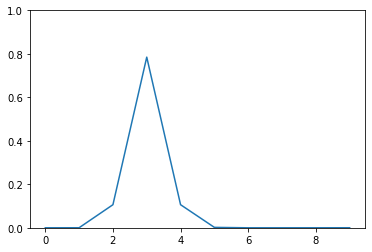

In [43]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

alpha=0.1
temp = 0.1
dummy = np.array([0.05,0.2,0.8,1,0.8,0.4,-0.1,0,0.1,0.2])*10*alpha
sm = softmax(dummy / temp)
plt.plot(sm / np.sum(sm))
plt.ylim(0,1)
